#### 1 - Download Housing Dataset:

In [22]:
import requests

# Dataset URL
url = 'https://raw.githubusercontent.com/ageron/handson-ml2/refs/heads/master/datasets/housing/housing.csv'

# Local filename to save the CSV
filename = 'datasets/housing.csv'

# Fetch and save the CSV
response = requests.get(url)

if response.status_code == 200:
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"CSV file downloaded and saved as {filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

CSV file downloaded and saved as datasets/housing.csv


#### 2 Basic Pre-Processing

Remove NAN, Map Location Classification

In [23]:
import pandas as pd

# Open the CSV file
housing_dataset = pd.read_csv('datasets/housing.csv')

# Remove NAN
housing_dataset.dropna(inplace=True)

# Map Ocean Proximity
mapping = {"ISLAND" : 0, 'NEAR OCEAN': 1, 'NEAR BAY': 2, "<1H OCEAN": 3, 'INLAND': 4}
housing_dataset['ocean_proximity_encoded'] = housing_dataset['ocean_proximity'].map(mapping)

# Count the number of entries per ocean_proximity category
counts = housing_dataset['ocean_proximity'].value_counts()

print("Ocean Proximity Counts:\n", counts)

Ocean Proximity Counts:
 ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64


#### 3. Create Pairplot of attributes for intial pattern recognition

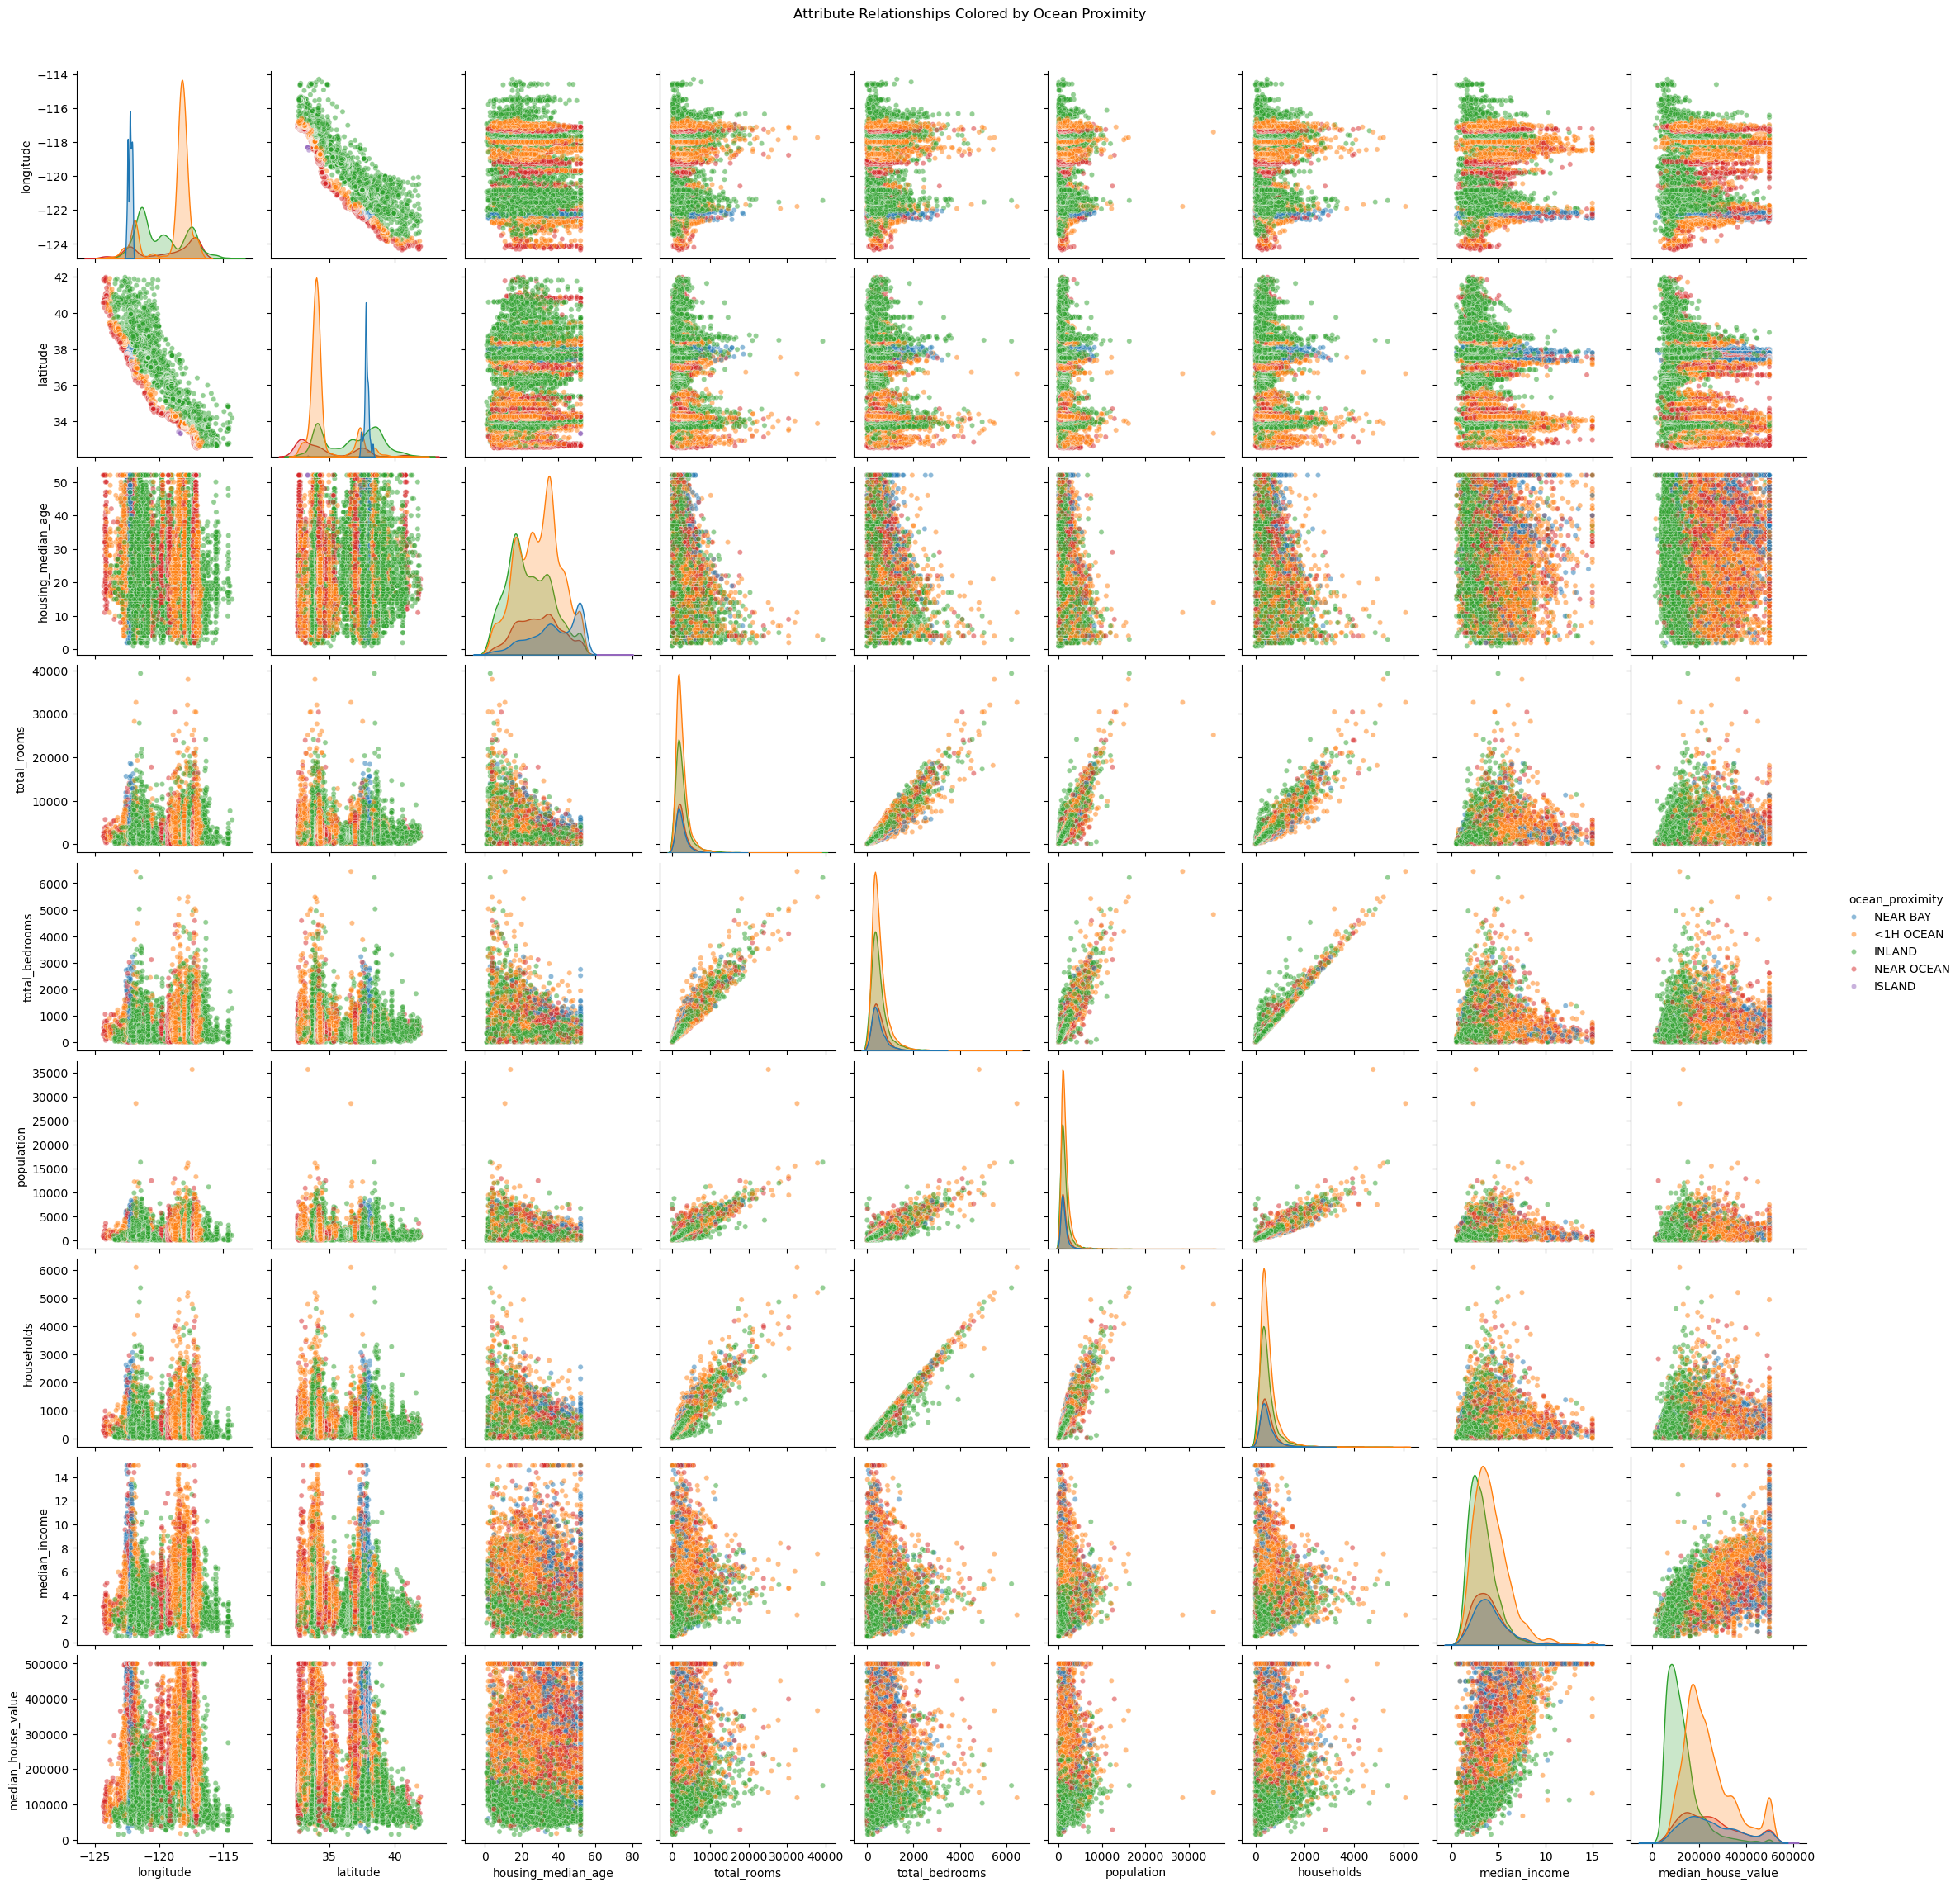

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
sns.pairplot(housing_dataset, hue='ocean_proximity', 
             vars=['longitude', 'latitude', 'housing_median_age', 
                   'total_rooms', 'total_bedrooms', 'population', 
                   'households', 'median_income', 'median_house_value'],
             plot_kws={'alpha': 0.5, 's': 20})  # alpha for transparency, s for point size

plt.suptitle('Attribute Relationships Colored by Ocean Proximity', y=1.02)
plt.show()

#### 3.1 Graph Longitude/Latitude Attributes to Judge Data Patterns in Location Classification & Housing Value

Plot Longitude/Latitude to map classifications

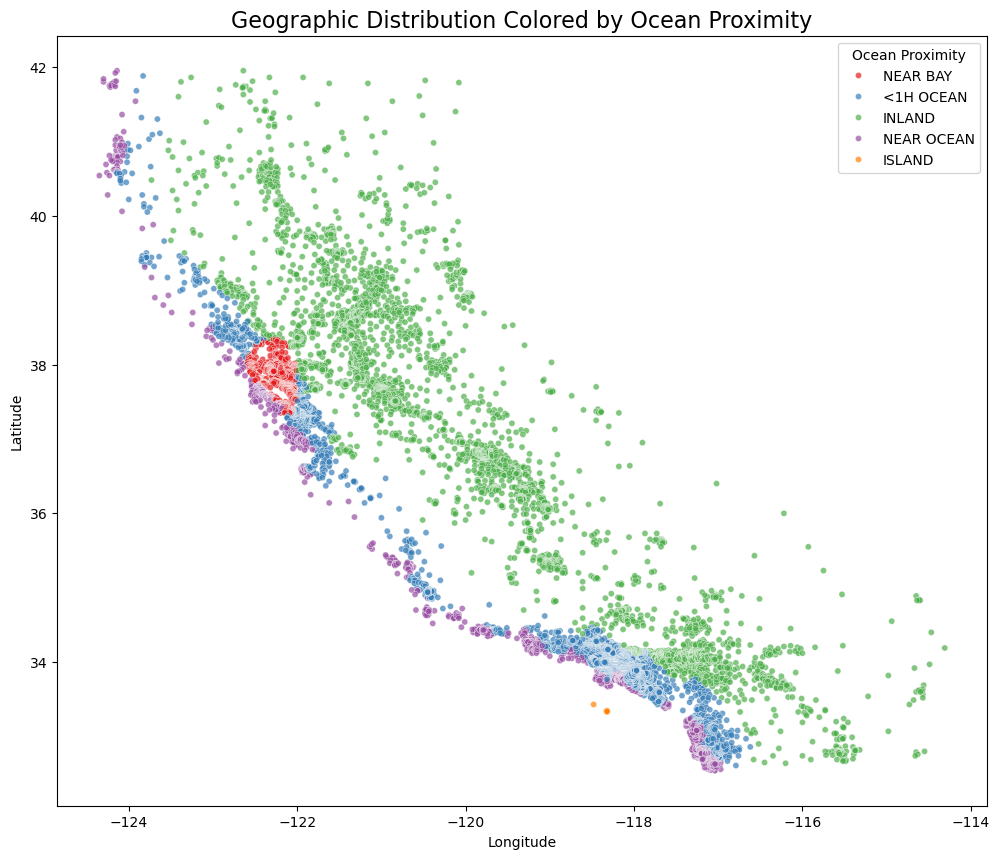

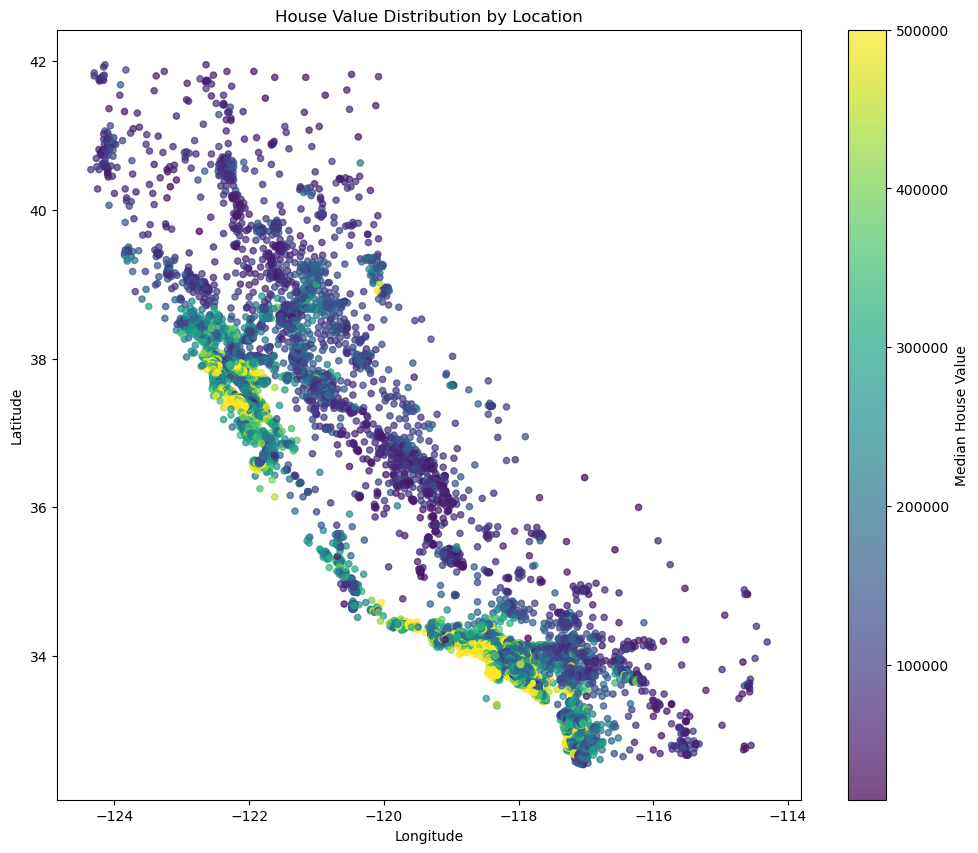

In [25]:
# Plot Ocean Proximity
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    data=housing_dataset,
    x='longitude',
    y='latitude',
    hue='ocean_proximity',
    palette='Set1', 
    s=20,
    alpha=0.7
)

# Title and layout
plt.title('Geographic Distribution Colored by Ocean Proximity', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Ocean Proximity', loc='upper right')
plt.show()

# Plot Housing Value
plt.figure(figsize=(12, 10))
sc = plt.scatter(
    housing_dataset['longitude'],
    housing_dataset['latitude'],
    c=housing_dataset['median_house_value'],
    cmap='viridis',  # You can choose other colormaps like 'plasma', 'coolwarm', etc.
    s=20,
    alpha=0.7
)


plt.colorbar(sc, label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Value Distribution by Location')
plt.show()

Relationships between coodinates, ocean proximity & median housing value is clear. This data should be used to classify housing location.

#### 3.2 Plot Housing Age/Value to Identify Patterns

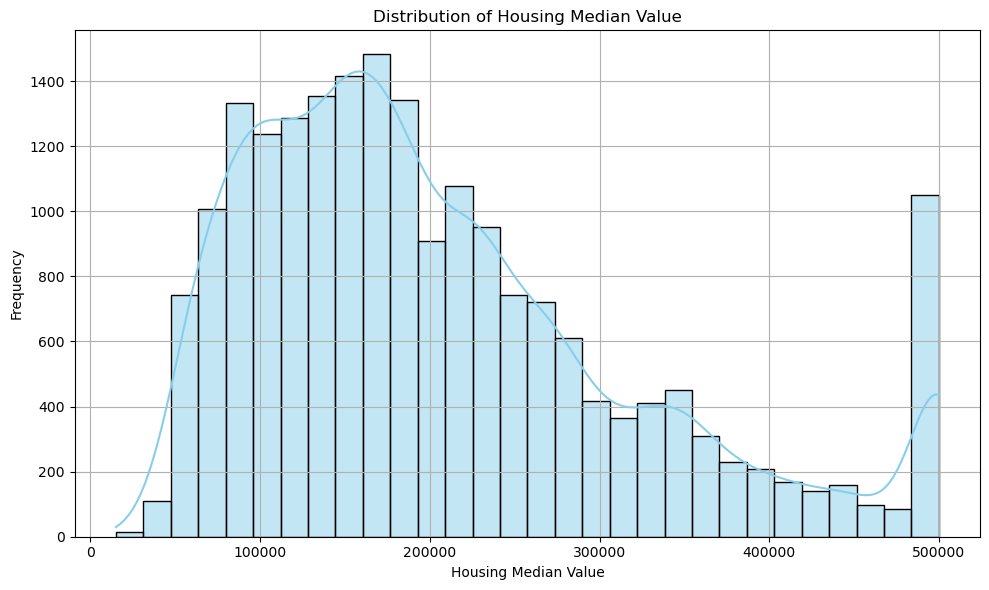

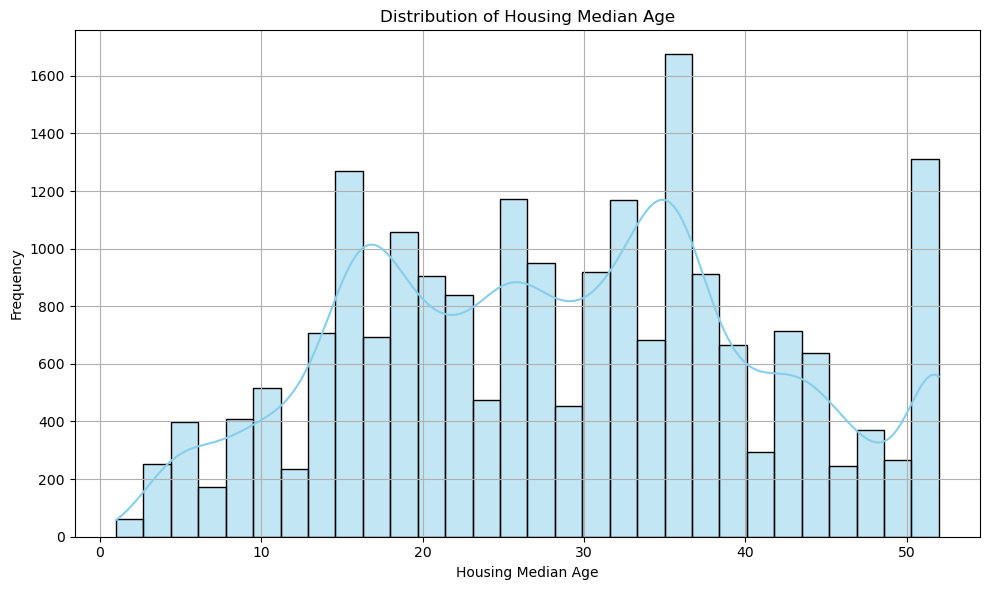

In [26]:
# Check the upper bounds on age/value as graphs show sharp lines at maximum

# Plot the value distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing_dataset['median_house_value'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Housing Median Value')
plt.xlabel('Housing Median Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing_dataset['housing_median_age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Housing Median Age')
plt.xlabel('Housing Median Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

There is a signifigant bump on the top end of the dataset, indicating median age/value greater than a certain value is capped at a lower figure.

#### 4. Refine Data Attributs to Get Data for Median Home Value Analysis
1. convert totals --> per house
2. remove upper cap values on age/value to improve pattern analysis

In [27]:
# convert to per house values
housing_dataset['avg_rooms_per_house'] = housing_dataset['total_rooms'] / housing_dataset['households']
housing_dataset['avg_bedrooms_per_house'] = housing_dataset['total_bedrooms'] / housing_dataset['households']
housing_dataset['avg_people_per_house'] = housing_dataset['total_bedrooms'] / housing_dataset['households']

# Remove Upper values for age / value to make dataset easier to analyze and remove noise
housing_dataset_cleaned = housing_dataset[housing_dataset['housing_median_age'] <= 51]
housing_dataset_cleaned = housing_dataset_cleaned[housing_dataset_cleaned['median_house_value'] <= 500000.0]
print(housing_dataset_cleaned.head())

    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -122.23     37.88                41.0        880.0           129.0   
1     -122.22     37.86                21.0       7099.0          1106.0   
8     -122.26     37.84                42.0       2555.0           665.0   
15    -122.26     37.85                50.0       1120.0           283.0   
18    -122.26     37.84                50.0       2239.0           455.0   

    population  households  median_income  median_house_value ocean_proximity  \
0        322.0       126.0         8.3252            452600.0        NEAR BAY   
1       2401.0      1138.0         8.3014            358500.0        NEAR BAY   
8       1206.0       595.0         2.0804            226700.0        NEAR BAY   
15       697.0       264.0         2.1250            140000.0        NEAR BAY   
18       990.0       419.0         1.9911            158700.0        NEAR BAY   

    ocean_proximity_encoded  avg_rooms_per_house  avg_be

#### 5. Identify Impact on Housing Value
Graph important attributes vs median housing value

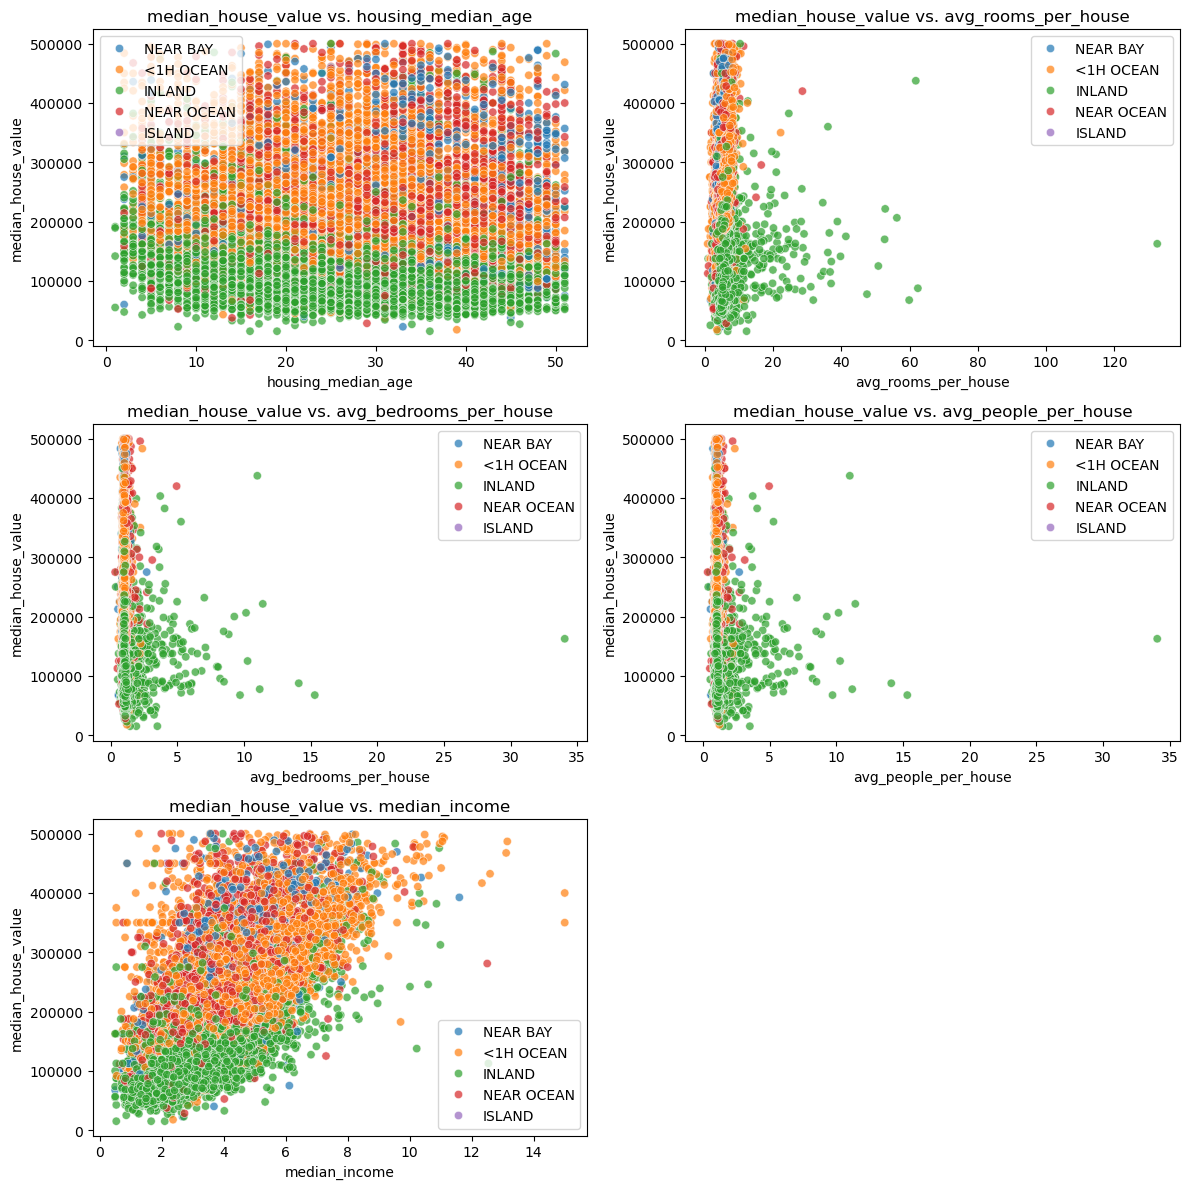

In [28]:
features = ['housing_median_age', 'avg_rooms_per_house', 'avg_bedrooms_per_house', 'avg_people_per_house', 'median_income']
target = 'median_house_value'

# Plot setup
n_cols = 2
n_rows = (len(features) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(
        x=housing_dataset_cleaned[feature],
        y=housing_dataset_cleaned[target],
        hue=housing_dataset_cleaned['ocean_proximity'],      
        alpha=0.7
    )
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'{target} vs. {feature}')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

We can conclude that the primary relationship is home value vs median income but the relationship is fairly weak. There is also a relationship between housing classification and housing value.

#### 6. Prepare Data for Model Training

1. Keep only necessary attributes
2. Save to csv for future use.

In [ ]:
# Keep only attributes deemed important/relevant
housing_dataset_processed = housing_dataset_cleaned[[
    'longitude', 'latitude', 'median_income', 'median_house_value',
    'ocean_proximity', 'ocean_proximity_encoded'
]].copy()

# Save to csv
housing_dataset_processed.to_csv('datasets/preprocessed_dataset.csv', index=False)